[120]Magna Graecia\
Sergio Enrico Pisoni 132855\
Sofia Papaioannou 132898\
Lefteris Verouchis 132873

In [13]:
from IPython.display import Image, display

# REPORT

## Exploratory data Analysis

Search domain knowledge

Check if the data is intuitive


Understand how the data was generated

Explore individual features

Explore pairs and groups of features

Clean up features

## Models experimentation

### RANDOM FOREST

As part of our initial experiments, we considered using Random Forest for both latitude and longitude prediction. Random Forest is a robust ensemble learning method that often performs well for regression tasks. 

We set the number of trees to be 20 with maximum depth dor each tree to be 25 for lattitude and 35 for lontitude, since we wanted to capture complex relationships in the data but not have the fear of overfitting. 

After training the models, we evaluated their performance using the Mean Absolute Error (MAE) metric. While Random Forest yielded reasonable results for first try and without compliting all the feature engineering that we added in the process, we observed that training times were relatively slow, especially with the large dataset and higher number of trees used in the ensemble.

So despite the effectiveness of Random Forest, we decided to explore XGBOOST due to lower training time.

In [14]:
# Train Random Forest model for latitude prediction
model_lat = RandomForestRegressor(n_estimators=20, max_depth=25, random_state=42, verbose=3)
model_lat.fit(X_train_lat, y_train_lat)

# Train Random Forest model for longitude prediction
model_lon = RandomForestRegressor(n_estimators=20, max_depth=35, random_state=42, verbose=3)
model_lon.fit(X_train_lon, y_train_lon)


NameError: name 'RandomForestRegressor' is not defined

### XGBOOST

Our final choice resided in XGbBoost due to its outstanding performance and relatively low training time.\
XGBoost is known for its ability to deliver high-quality predictions, especially when dealing with large, noisy datasets and a variety of features.\
Furthermore, XGBoost excels in handling missing data, feature interactions, and non-linear relationships, which makes it particularly well-suited for our dataset.\


## Feature Engineering


Feature engineering is a critical step in preparing data for meaningful analysis and predictive modeling, especially when dealing with complex datasets like AIS (Automatic Identification System). AIS data records extensive information on vessel locations, speeds, directions, navigational statuses,schedules and ports characteristics but it also comes with inherent challenges such as placeholder values, outliers, and inconsistent formats.

In this project, we used feature engineering to transform raw AIS and port data into a more accurate, comprehensive dataset. The goal was to enhance the quality and relevance of the data by refining existing features and creating new ones, making the information more suitable for understanding vessel behaviors, predicting arrival times, and optimizing routes and get more accurate predictions. By addressing missing values, aligning timestamps, and creating meaningful flags and derived features, we tried to take advantage from the most useful attributes.

In this section we document the specific steps taken, the rationale behind each transformation,in order to succeed it.

### Feature selection

-> Cleaning Ports Data: To streamline analysis, we removed unnecessary columns from the ports data, such as name, portLocation, UN_LOCODE, countryName, and ISO. We kept only the attributes that we considered essential and were important to give in order to train our model and get better results (portId, latitude, longitude). This reduced data size and minimized potential redundancies.
<br>-> Renaming Columns: We renamed latitude and longitude in the ports dataset to port_latitude and port_longitude. This renaming prevented confusion with vessel latitude and longitude values, making the dataset more intuitive and easier to work with.


In [ ]:
ports = pd.read_csv('ports.csv', sep ='|')
# Clean port data
ports = ports.drop(columns=['name', 'portLocation', 'UN_LOCODE', 'countryName', 'ISO'], errors='ignore')
# Rename latitude and longitude to distinguish them
ports = ports.rename(columns={
    'latitude': 'port_latitude',
    'longitude': 'port_longitude'
})

### Feature Preprocessing 

Handling default values, outliers, and missing data was essential for improving data consistency and accuracy.
<br><br>
Replacing Default and Outlier Values: AIS data uses certain default values to indicate unavailable or invalid measurements. For example, cog (course over ground) values are defaulted to 360 when not available. We replaced these default values with NaN, which allowed the model to ignore invalid values rather than treating them as valid data points but without any useful meaning.
<br>For cog: Replaced 360 with NaN and removed values above 360.
<br>For sog (speed over ground): Replaced 1023 with NaN, as this default represents unavailable data.
<br>For rot (rate of turn): Replaced 128 with NaN, indicating missing values. Additionally, values of +127 and -127 signify an uncertain rate of turn. We replaced these values with extreme values (200 and -200, respectively) and added an uncertain_rot flag to mark these rows.
<br>For heading: Replaced 511 with NaN, which indicates an unavailable heading measurement.
This preprocessing step ensures that only valid valued are being taken into account, and helps our model to perform better without biased values.

<br>Adding Flags: we added an uncertain_rot flag to identify rows where rot values were uncertain (200 or -200). Additionally, we created an isMoored flag to denote when vessels were moored, derived from the navstat variable (navstat = 5 indicates a moored vessel). This feature helped identify vessels that were stationary, which could influence movement-based analyses.

In [ ]:
def preprocess(df):
    # Replacing default with Nan bacause too close to valid values, eliminate non valid values
    df['cog'] = df['cog'].replace(360, np.nan)
    df = df[(df['cog'] <= 360) | (df['cog'].isna())]

    # Replacing default with Nan bacause too close to valid values
    df['sog'] = df['sog'].replace(1023, np.nan)

    # Replacing default with Nan bacause too close to valid values
    # Changing uncertain values to bigger number to be further away from sample pool
    # Adding uncertainty flag
    df['rot'] = df['rot'].replace(128, np.nan)
    df['rot'] = df['rot'].replace({127: 200, -127: -200})
    df['uncertain_rot'] = np.where(df['rot'].isin([200, -200]), 1, 0)

    # Replacing default value with NaN to not get taken in consideration by regression
    df['heading'] = df['heading'].replace(511, np.nan)

    # Adding a "is moored?" flag
    df['isMoored'] = (df['navstat'] == 5).astype(int)   

    # Time Handling 
    df['time'] = pd.to_datetime(df['time'], errors='coerce').dt.tz_localize('UTC')
    # Standardize eta
    df['etaRaw'] = df['etaRaw'].fillna(0)
    df['etaRaw'] = df['etaRaw'].apply(lambda x: f"{2024}-{x}")
    df['etaRaw'] = pd.to_datetime(df['etaRaw'], errors='coerce').dt.tz_localize('UTC')
    df.rename(columns={'etaRaw': 'etaStd'}, inplace=True)
    # Handle first month of the years ETA year to be 2023
    df['etaStd'] = df.apply(lambda row: row['etaStd'].replace(year=row['etaStd'].year - 1)
                            if row['etaStd'].month in [11, 12] and row['time'].month in [1, 2] 
                            else row['etaStd'], axis=1) 

    # FEATURE ENGINEERING
    # Get day of the week 
    df['dayofweek'] = df['time'].dt.dayofweek
    df['eta_dayoftheweek'] = df['etaStd'].dt.dayofweek 
    # Converts time and eta to seconds and add difference between the two
    df['time_seq'] = df['time'].astype(int) / 10**9  
    df['eta_seq'] = df['etaStd'].astype(int) / 10**9 
    df['estimated_time_left'] = df['time_seq'] - df['eta_seq']
    # Add port coordinates
    df = pd.merge(df, ports, on='portId', how='left')
    # Add a three days rolling average for the AIS data 
    df['sog_mean'] = df.groupby('vesselId', group_keys=False).apply(
    lambda x: x.sort_values('time').rolling('3D', on='time')['sog'].mean())
    df['cog_mean'] = df.groupby('vesselId', group_keys=False).apply(
    lambda x: x.sort_values('time').rolling('3D', on='time')['cog'].mean())
    df['rot_mean'] = df.groupby('vesselId', group_keys=False).apply(
    lambda x: x.sort_values('time').rolling('3D', on='time')['rot'].mean())
    df['heading_mean'] = df.groupby('vesselId', group_keys=False).apply(
    lambda x: x.sort_values('time').rolling('3D', on='time')['heading'].mean())
    
    return df

#### Timestamp Handling and Date Features
Time and ETA Standardization: Both time and etaRaw columns were converted to standardized datetime formats, in order to make more accurate time-based calculations.

time was converted to a timezone-aware UTC datetime.

etaRaw was standardized to etaStd, with missing values filled as 0. The format was modified to incorporate the current year (2024-) for ease of handling.
<br>Adjusting ETA Across Years: For vessels scheduled to arrive early in the year (January or February) but reporting etaRaw in November or December, we adjusted the year of etaStd to the previous year (2023). This adjustment avoided errors in estimated time calculations by aligning cross-year arrivals with correct temporal references.

Creating Derived Time Features: To capture weekly trends in vessel activity, we created two new features, dayofweek and eta_dayoftheweek, representing the weekday for both the time and etaStd columns. This step allowed us to capture weekly patterns that may influence vessel schedules and movement behaviors.

Converting Time to Seconds and Calculating Differences: The time and etaStd columns were converted to Unix timestamps (time_seq and eta_seq, respectively), representing the seconds since the Unix epoch. We then computed estimated_time_left as the difference between these two features, representing the remaining time for a vessel to reach its destination.
This feature, estimated_time_left, provides an estimated arrival time which is useful for making predictions. 

Merging Port Coordinates: The next step was to add port coordinates to the AIS dataset. I merged the AIS dataset with ports data on the portId column, using a left join to ensure that each vessel’s record retained the port’s latitude and longitude (port_latitude, port_longitude).
Including port location data is essential for geospatial analysis, providing context for vessel proximity to ports and supporting models that incorporate spatial features.

To smooth out short-term fluctuations and capture broader trends, we applied a 3-day rolling average to key navigation variables: sog (speed over ground), cog (course over ground), rot (rate of turn), and heading. These rolling averages were computed individually for each vessel by grouping data by vesselId and sorting by time.
For instance, sog_mean represents the average speed of a vessel over a 3-day window. By doing this, we create a more stable trend for each vessel's movement over time, making easier for our model to learn and predict consistent behaviors.

## Model Interpretation
While XGBoost's algorithm is relatively simple and undestandable, it's behaviour expecially when trained on complex data can be cosidered almost a black box.\
For that reason we extracted information about feature importance and partial dependencies from our model to understand better how it's working.

### Feature importance
Feature importance plots give a great insight on how a model is making his decisions. It can guide the programmer in choosing how to proceed with the model development.\
Let's take a look to our's model results:

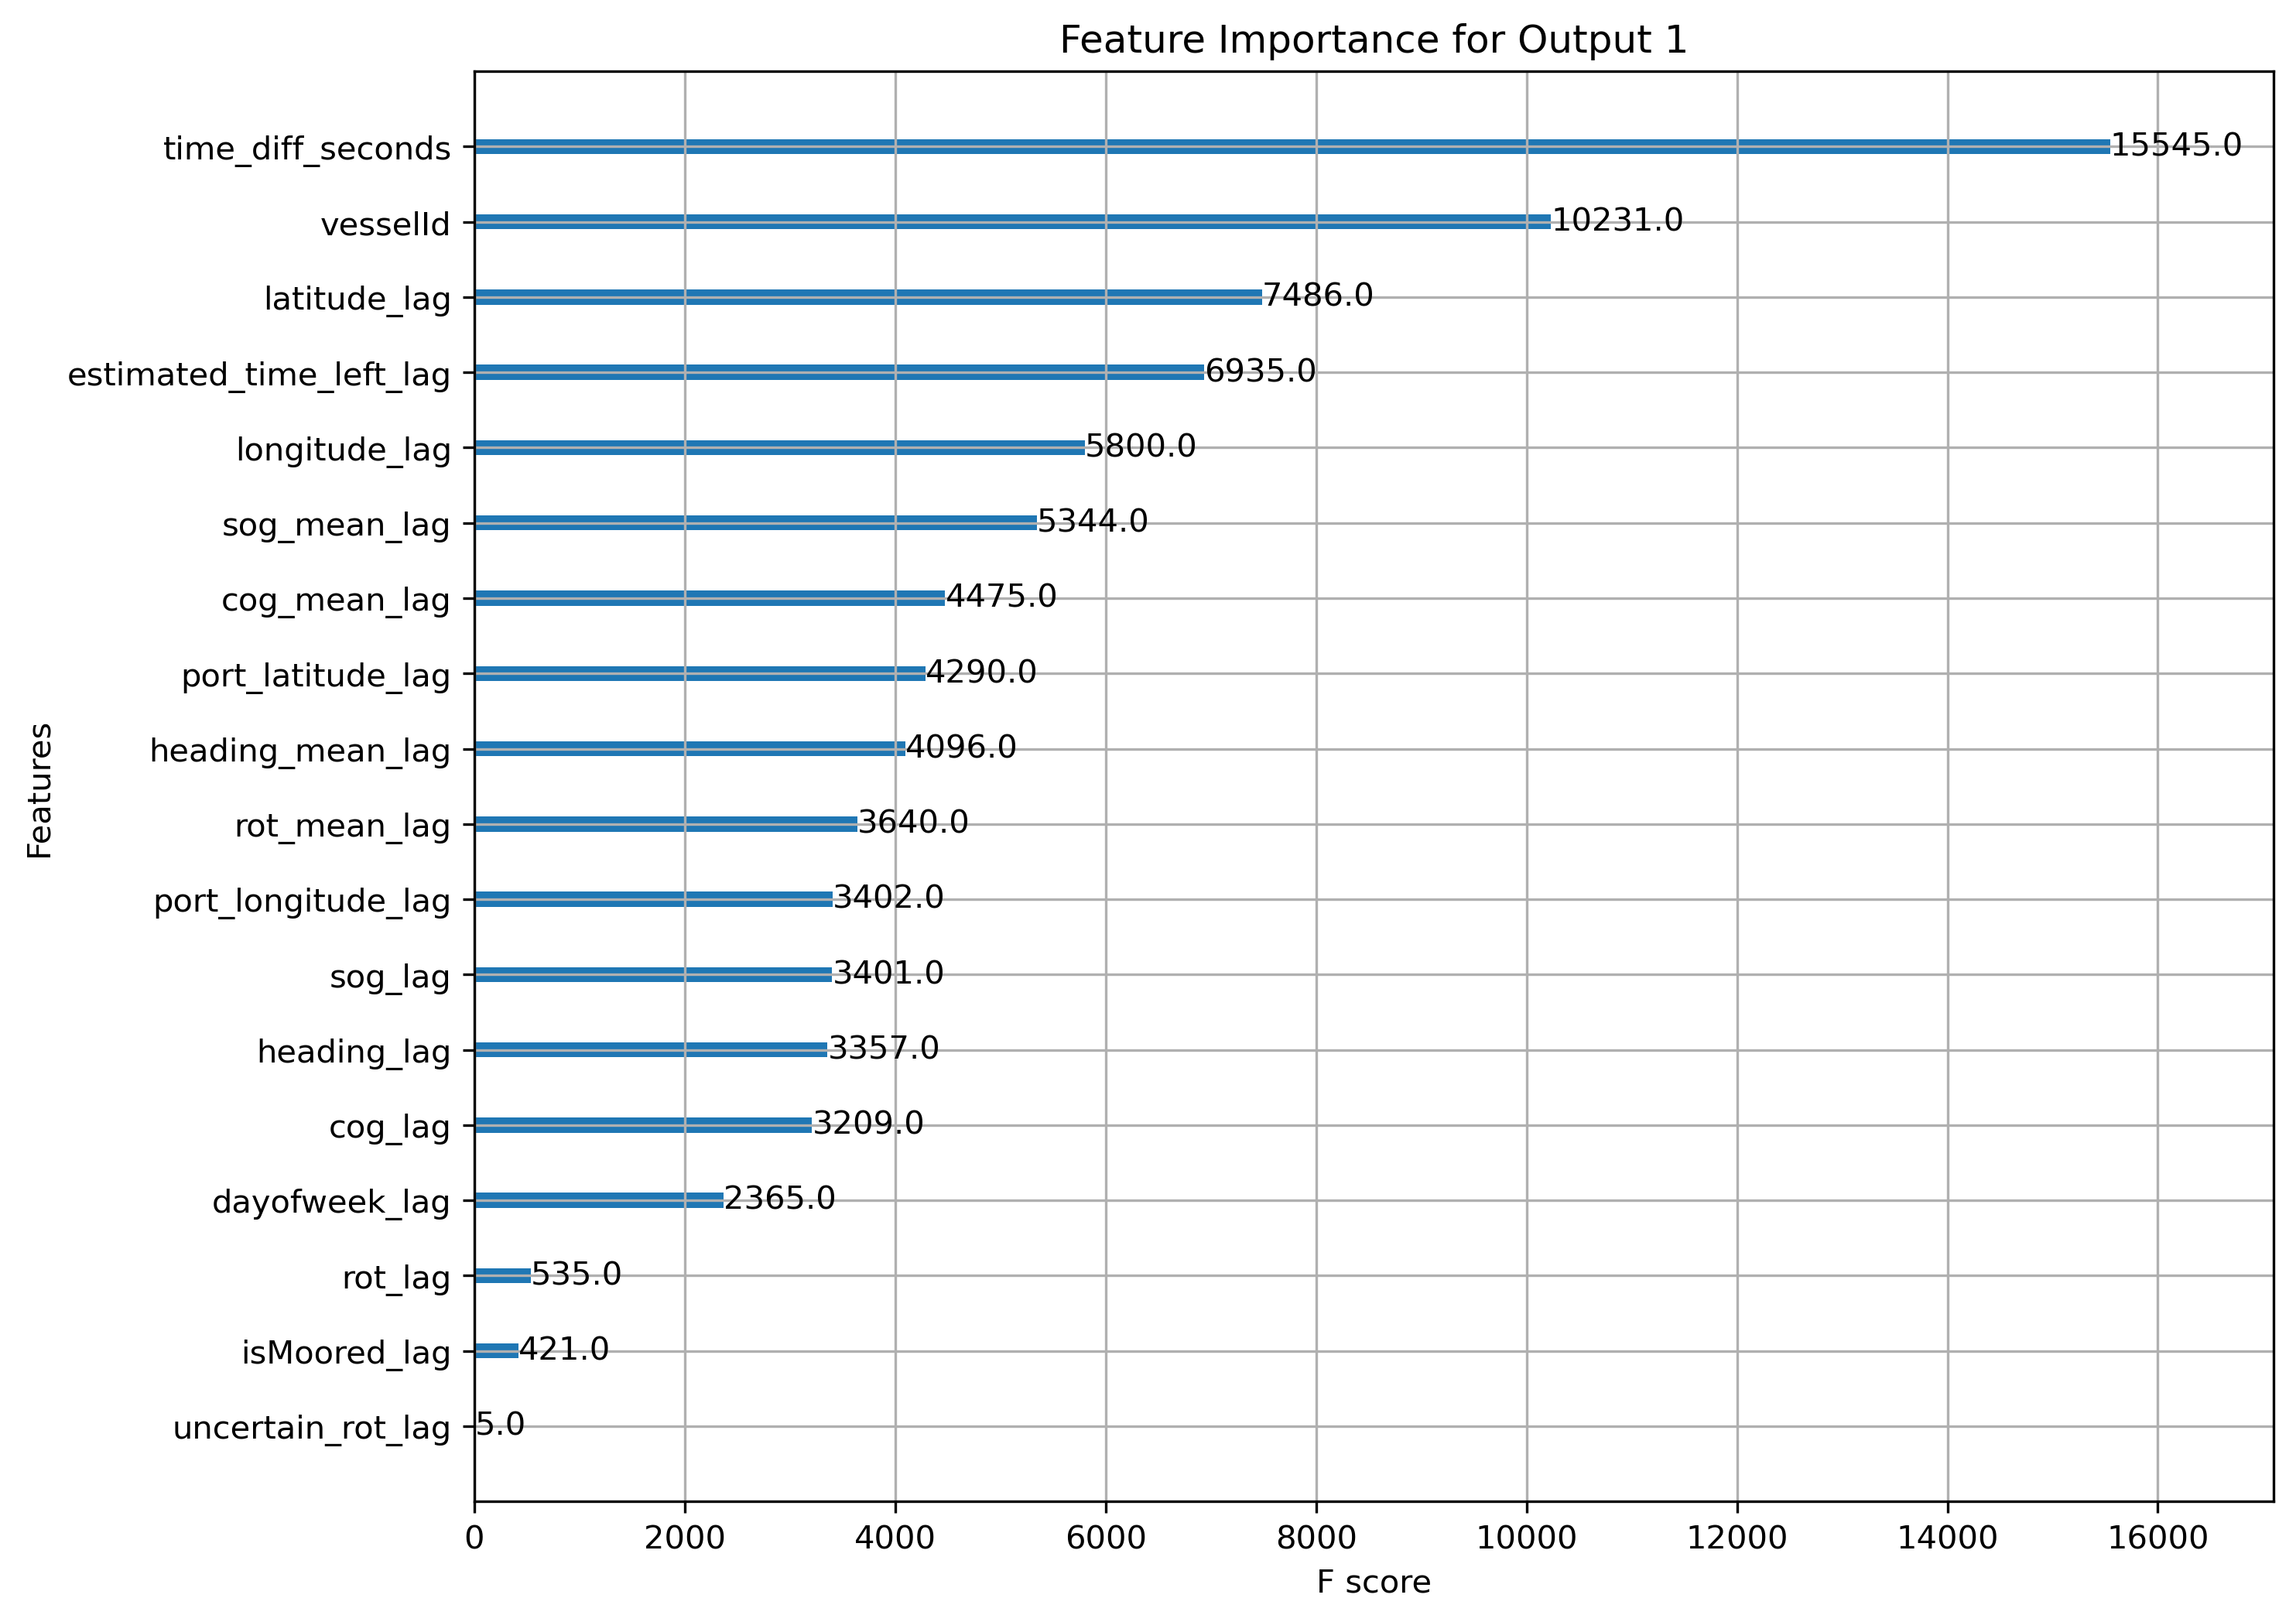

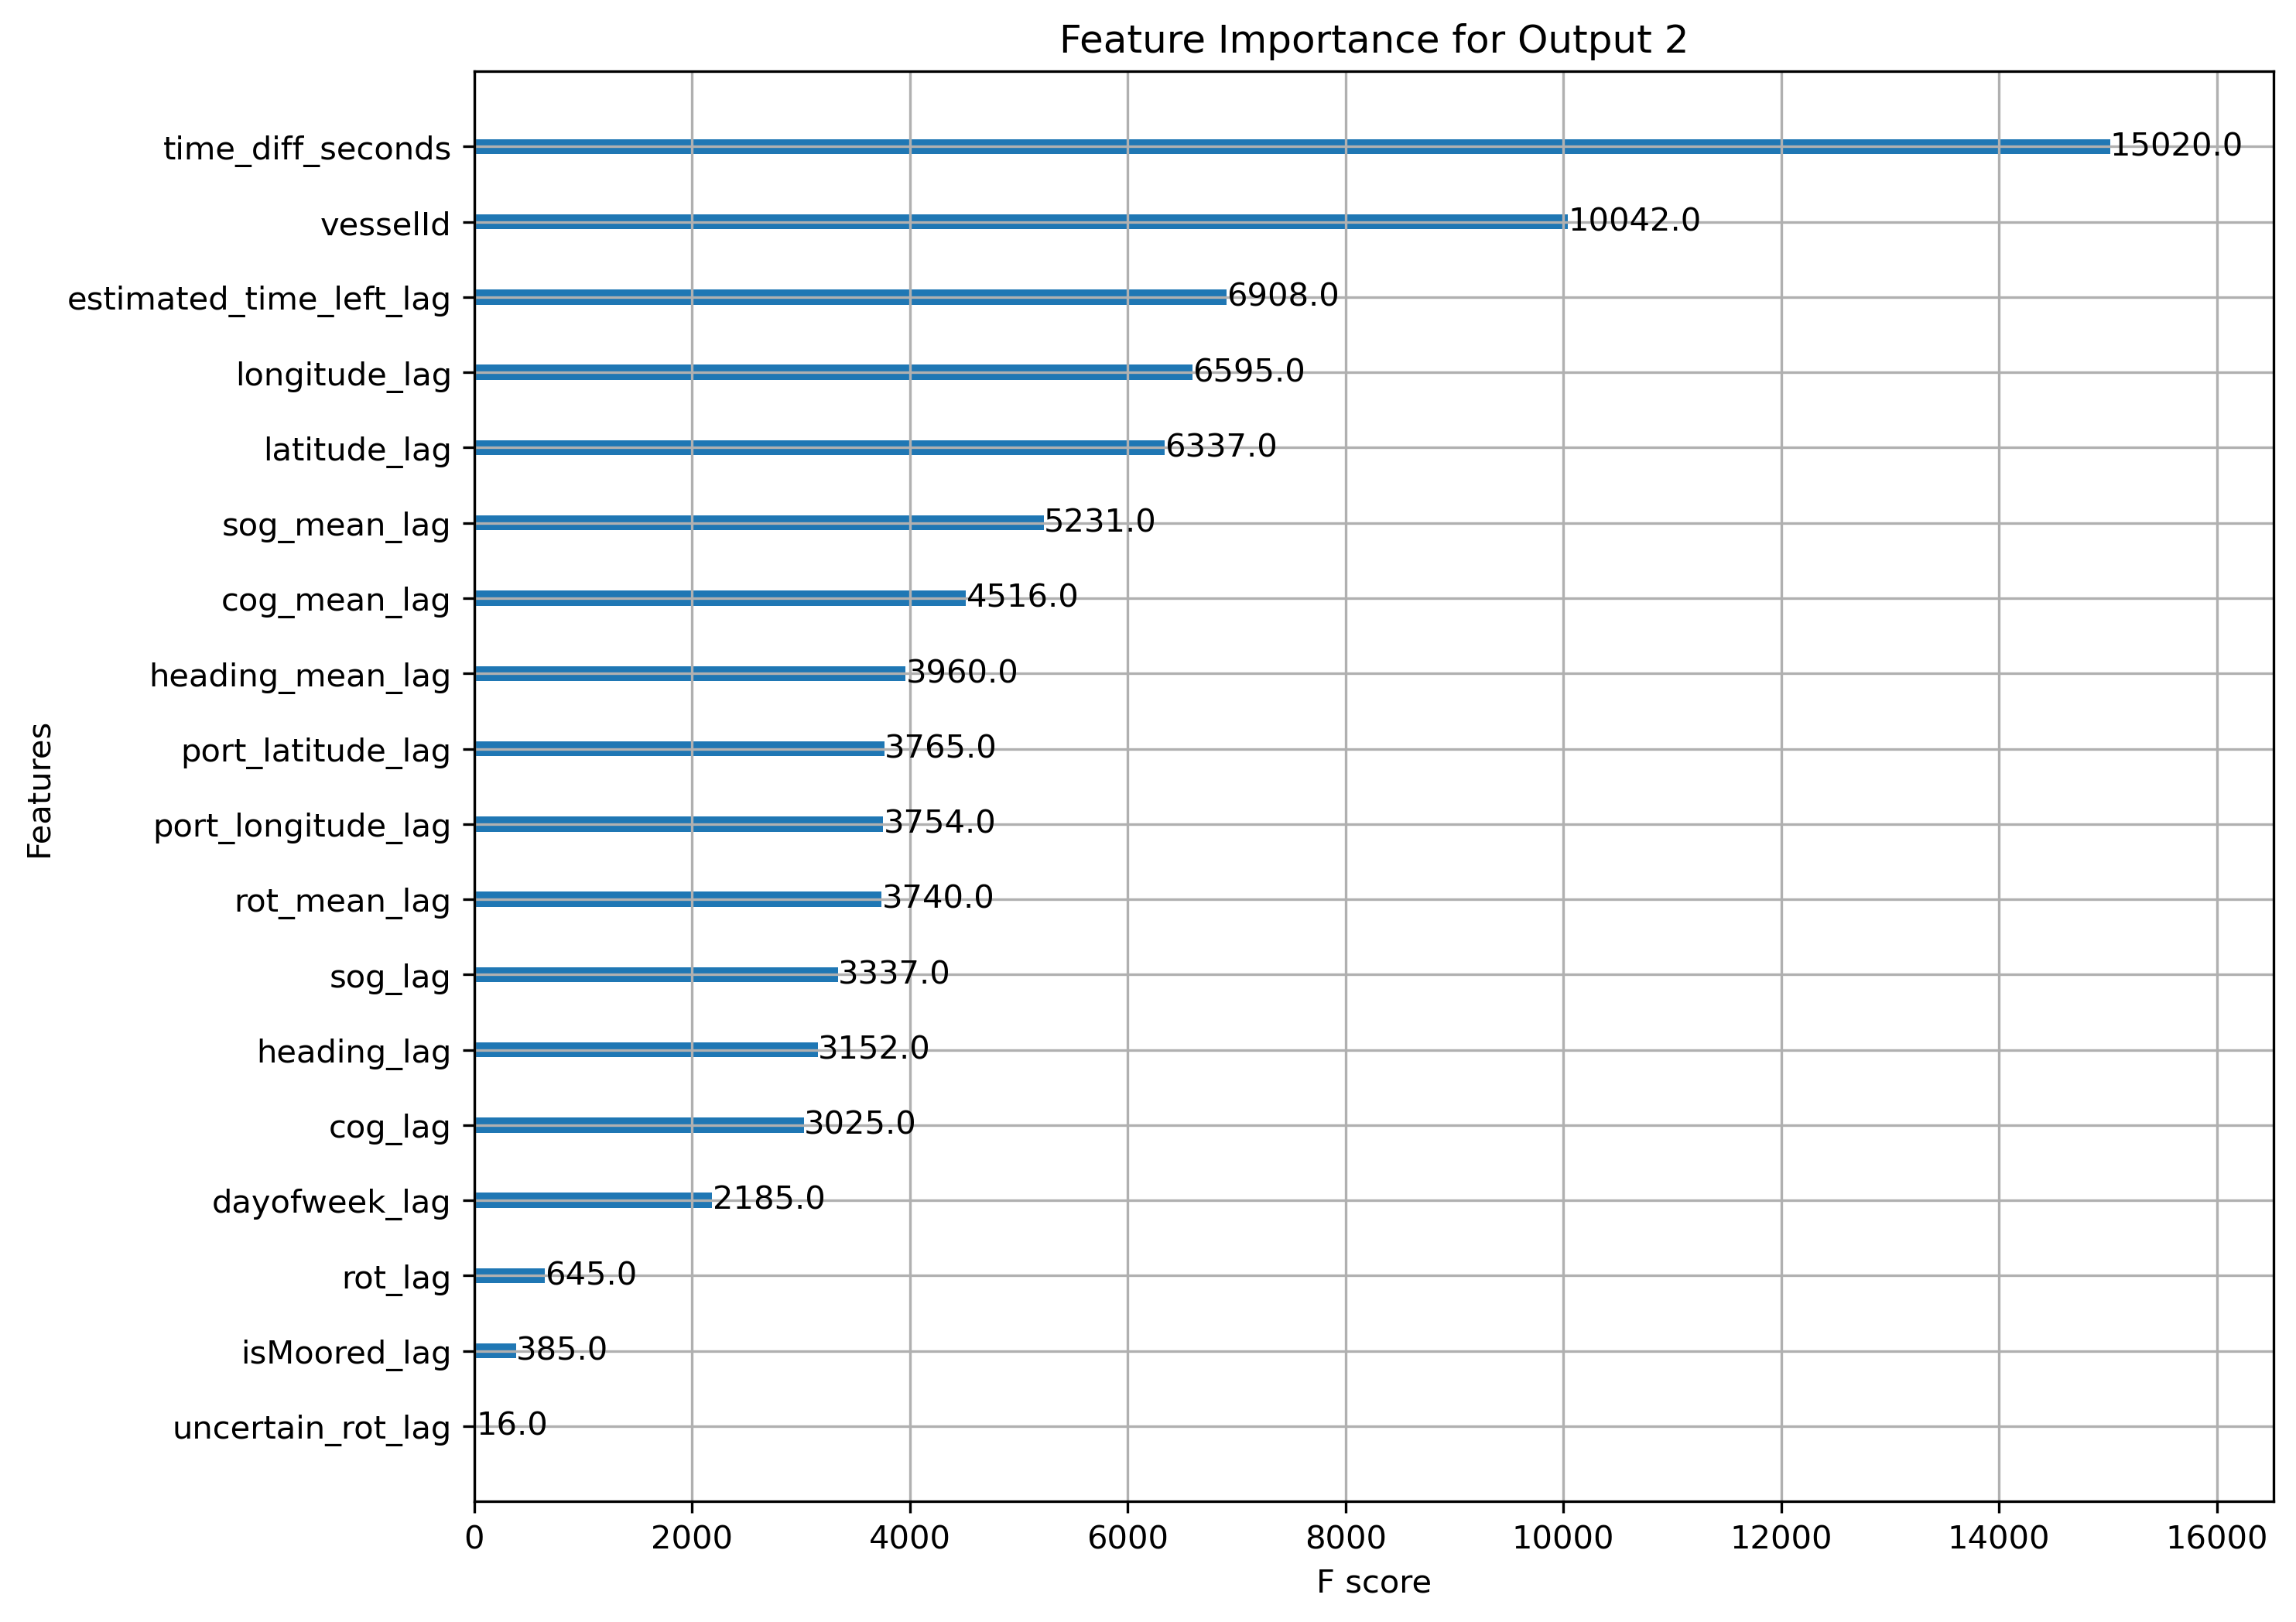

In [ ]:
display(Image(filename='plots/feature_importance_output_1.png'), Image(filename='plots/feature_importance_output_2.png'))

From these plots we can clearly see that out feature engineering worked.\
The higher the F score the higher the number of decisions that the model trees take based on that feature.\
From the plot is clear that our features such as port coordinates, time to ETA and rolling means, cause the greatest separation in the model's decisions.\
In particular, creating numerous training sets with different time horizons made the time_diff feature the most important to predict the coordinates.\
On the other hand, the model is basically never using only the isMoored flag and the uncertain_rot flag, something to keep in mind in the future when implementing flags in a Data Frame filled with other more complex features.\
